# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier

from sklearn.pipeline import Pipeline

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data of general population
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')

#azdias = pd.read_csv(r'azdias.csv')


C:\Users\Joykaus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [58]:
#load in the data of customers of mail order company

customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

#customers = pd.read_csv(r'customers.csv')

C:\Users\Joykaus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [ ]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [35]:
# Load the file that describes attributes of the variables used in our datasets
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
del feat_info['Unnamed: 0']
feat_info.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [36]:
# It looks like the first 5 columns are for AGER_TYP (and so on) but only the first row of the
# attribute column is filled in and the rest are NaNs.  Therefore, forward-fill this column, redefine
# this as the attribute column, and view the first 10 lines of the altered dataframe. 
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,NaN,1,< 30 years
7,ALTERSKATEGORIE_GROB,NaN,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,NaN,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,NaN,4,> 60 years


In [37]:
# finding all unknown and no values in this dataset
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]


In [38]:
feat_info.tail()

,Attribute,Description,Value,Meaning
2229,WOHNLAGE,residential-area,-1,unknown
2230,WOHNLAGE,NaN,0,no score calculated
2238,WACHSTUMSGEBIET_NB,growing area (population growth in the last 5 ...,"-1, 0",unknown
2244,W_KEIT_KIND_HH,likelihood of a child present in this household,"-1, 0",unknown
2251,ZABEOTYP,typification of energy consumers,"-1, 9",unknown


In [39]:
# Convert to a list of strings
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [40]:
# Because both of the first 2 rows of feat_info belong to the same attribute, combine the values 
# for each row into a single list of strings

notknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    notknowns.append(_)
    
notknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(notknowns)], axis=1)
notknowns.columns = ['attribute', 'missing_or_unknown']

In [41]:
feat_info= notknowns
feat_info

,attribute,missing_or_unknown
0,AGER_TYP,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1, 0]"
2,ALTER_HH,[0]
3,ANREDE_KZ,"[-1, 0]"
4,BALLRAUM,[-1]
...,...,...
287,WOHNDAUER_2008,"[-1, 0]"
288,WOHNLAGE,"[-1, 0]"
289,WACHSTUMSGEBIET_NB,"[-1, 0]"
290,W_KEIT_KIND_HH,"[-1, 0]"


In [30]:
# Using the notknowns dataframe, identify missing or unknown data values and convert them to NaNs.

start = time.time()
    
for row in notknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_lst = notknowns.loc[notknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias.loc[:, row].isin(na_lst)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

365.28412675857544

In [31]:
#View the altered azdias dataframe.The 1st, 2nd, 3rd, and 5th rows of the AGER_TYP column would have been converted
#from -1 to NaN. 
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


In [32]:
# Perform an assessment of how much missing data there is in each column of the dataset.
col_na = azdias.shape[0] - azdias.count()
col_na.sort_values()

LNR                              0
D19_WEIN_FEINKOST                0
D19_VOLLSORTIMENT                0
D19_VERSICHERUNGEN               0
D19_VERSI_ONLINE_DATUM           0
                             ...  
D19_BANKEN_OFFLINE_DATUM    871535
D19_TELKO_ONLINE_DATUM      883018
ALTER_KIND3                 885051
TITEL_KZ                    889061
ALTER_KIND4                 890016
Length: 366, dtype: int64

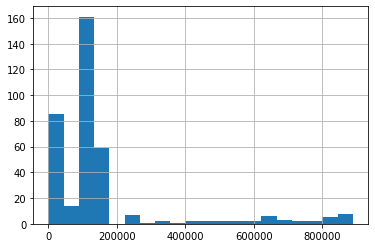

In [33]:
# Investigate patterns in the amount of missing data in each column.
col_na.hist(bins=20);

In [34]:
# Define function to find columns with 20% missing values
def find_cols_missing_percent_data(df, pct):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing values in its columns
    OUTPUT:
        missing_pct_cols: (list), list of columns with more than pct missing values
    '''
    missing_percent_cols = [col for col in df.columns if (df[col].isnull().sum()/df.shape[0]) * 100 > pct]
    return missing_percent_cols

In [35]:
# Find the name of columns with more than 20% missing values
cols_to_drop = find_cols_missing_percent_data(azdias, pct=20)
print(cols_to_drop)
azdias.drop(cols_to_drop, axis=1, inplace = True)
azdias.shape

['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']


(891221, 319)

In [36]:
# Determin data missing in each row of the dataset?
row_na = azdias.shape[1] - azdias.count(axis = 1)
row_na.head()

0    233
1      0
2      0
3      4
4      0
dtype: int64

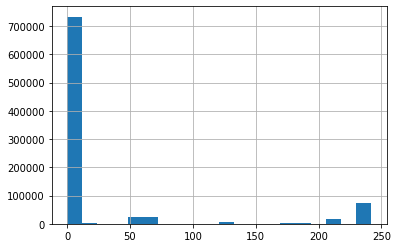

In [37]:
# Plot histogram of number of missing values
row_na.hist(bins=20);


In [38]:
# Remove rows which contain more than 10 missing values per row
rows_to_drop = azdias.index[row_na > 10]
print(rows_to_drop)
azdias.drop(rows_to_drop, axis=0, inplace = True)
azdias.shape

Int64Index([     0,     11,     12,     13,     14,     15,     17,     20,
                23,     24,
            ...
            891164, 891169, 891170, 891171, 891172, 891173, 891175, 891185,
            891187, 891203],
           dtype='int64', length=158732)


(732489, 319)

In [39]:
print (azdias.dtypes)

LNR                       int64
AKT_DAT_KL              float64
ANZ_HAUSHALTE_AKTIV     float64
ANZ_HH_TITEL            float64
ANZ_KINDER              float64
                         ...   
WOHNDAUER_2008          float64
WOHNLAGE                float64
ZABEOTYP                float64
ANREDE_KZ               float64
ALTERSKATEGORIE_GROB    float64
Length: 319, dtype: object


In [40]:
#Select and Re encode data

In [41]:
# create a list of categorical data from feat_info manually
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [42]:
#Find categorical variables: binary, multi-level, and which one needs to be re-encoded
     
for i in categorical:
    if i in azdias.columns:
        print(azdias[i].value_counts())

2.0    381860
1.0    350629
Name: ANREDE_KZ, dtype: int64
6B    53656
8A    50490
4C    43671
2D    32660
7A    32410
3C    32326
3D    31947
8B    31078
4A    30043
8C    29976
9D    26589
9B    25763
7B    22793
9C    22785
9A    19953
2C    17620
8D    16584
6E    15485
5D    13976
2B    13945
6C    13789
2A    11824
1D    11383
1A    10097
5A     9663
5B     9628
5C     8993
4B     8232
7C     8082
4D     8008
6A     6377
3A     5828
6D     5723
3B     5669
6F     5027
4E     4977
1E     4758
7D     4402
7E     4346
1C     3989
5F     3912
9E     3825
1B     3792
5E     3227
XX      282
Name: CAMEO_DEU_2015, dtype: int64
4.0    182228
3.0    135120
2.0    133711
5.0    104670
6.0     92035
1.0     84725
Name: CJT_GESAMTTYP, dtype: int64
6.0    277499
1.0    182264
5.0     97317
2.0     93587
4.0     52173
3.0     29649
Name: FINANZTYP, dtype: int64
1.0    419425
3.0    162109
8.0    145347
2.0      4231
4.0       820
6.0       556
5.0         1
Name: GEBAEUDETYP, dtype: int64
4.0  

In [43]:
# Only categorical variable that doesnt take integer values is OST_WEST_KZ which uses either W or o is re-encoded with 1 and 0. 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [44]:
# For categories in which column > 10 different values, drop for # simplicity as it will create too many categories to analyze
cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE','EINGEFUEGT_AM']

# For categories in which columns < 10 levels, re-encode using dummy variables.
cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [45]:
# Drop categorical columns with 10 or more values
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(732489, 311)

In [46]:
# Create dummy variables for columns with less than 10 
# unique values then drop the original columns
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print(azdias.shape)

azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)

azdias.shape


(732489, 374)


(732489, 361)

In [47]:
# replacing values for CAMEO_INTL_2015
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX',-1)

In [48]:
# replacing values for CAMEO_DEUG_2015
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X',-1)

In [49]:
#Create a cleaning function

In [33]:

# Create a cleaning function so the same changes can be done on the customer dataset as it was on the
# general population dataset. 

def clean_data(x, notknowns):
    """
   
    INPUT: 
        azdias: Population/Customer demographics DataFrame
        feat_info: feat info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # Convert missing values to Nans
    for col in x.columns:
        if x[col].dtype == np.int64:
            x[col] = x[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in notknowns['attribute']:
        if row in x.columns:
            na_map = notknowns.loc[notknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = x.loc[:, row].isin(na_map)
            x.loc[na_idx, row] = np.NaN
        else:
            continue

   # remove selected columns, ...
    # These columns were the ones above that had
    # > 200000 missing values in the azdias dataframe
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 
                    'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12', 'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 
                    'D19_BANKEN_OFFLINE_DATUM', 'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
                    'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM', 'D19_GESAMT_OFFLINE_DATUM',
                    'D19_GESAMT_ONLINE_DATUM', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_LETZTER_KAUF_BRANCHE',
                    'D19_LOTTO', 'D19_SOZIALES', 'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM', 
                    'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM', 'D19_TELKO_ONLINE_QUOTE_12', 
                    'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24', 'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
                    'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24',
                    'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
                    'KBA05_ANTG4', 'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    
    x.drop(cols_to_drop, axis=1, inplace = True)
    
    # remove selected rows, ...
    # These are rows which have >25 missing values
    row_na = x.shape[1] - x.count(axis = 1)
    rows_to_drop = x.index[row_na > 10]
    x.drop(rows_to_drop, axis=0, inplace = True)
    
    # select, re-encode, and engineer column values
    x['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(x[col], prefix = col)
        x = pd.concat([x, dummy], axis = 1)
        
    x.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE','EINGEFUEGT_AM']
    
    x.drop(cols_to_drop, axis=1, inplace = True)
    
    
    # replacing values for CAMEO_INTL_2015
    x['CAMEO_INTL_2015'] = x['CAMEO_INTL_2015'].replace('XX',-1)
    
    # replacing values for CAMEO_DEUG_2015
    x['CAMEO_DEUG_2015'] = x['CAMEO_DEUG_2015'].replace('X',-1)
    
    
    # Return the cleaned dataframe.
    return x

In [59]:
# Determine the shape of the customers dataframe
customers.shape

(191652, 369)

In [60]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [61]:
# Look further into CUSTOMER_GROUP column
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [62]:
# Look further into the ONLINE_PURCHASE column
customers['ONLINE_PURCHASE'].value_counts()


0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [63]:
# Look further into PRODUCT_GROUP column
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [64]:
# View the 3 extra columns count(there are no NaNs)
customers['CUSTOMER_GROUP'].count(), customers['ONLINE_PURCHASE'].count(), customers['PRODUCT_GROUP'].count()

(191652, 191652, 191652)

In [65]:
# Run the clean_data function on the customers dataset
customers = clean_data(customers, notknowns)

In [66]:
# Determine the shape of the customers dataframe after cleaning
customers.shape

(131204, 363)

In [67]:
# View the first few lines of the customers dataframe after cleaning
customers.head()


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,9626.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,1,1,0,0,0,0,0,1,1,0
2,143872.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,1,1,0,0,0,1,0,0,0,1
3,143873.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,...,0,1,0,0,1,0,0,0,1,0
4,143874.0,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,0,1,0,0,0,1,0,0,0,1
5,143888.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,7.0,...,0,1,0,0,0,1,0,0,0,1


In [68]:
azdias.head(2)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
1,910220,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0,1,0,0,0,0,0,1,0,1
2,910225,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0,1,0,0,0,0,1,0,1,0


In [69]:
# Determine the columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
customers.columns[~customers.columns.isin(azdias.columns)]

Index(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype='object')

In [70]:
# Determine the columns that are in the cleaned azdias dataframe
# but not the cleaned customers dataframe
azdias.columns[~azdias.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [71]:
# Find index of the GEBAEUDETYP_5.0 column in the azdias dataframe
column_index = azdias.columns.get_loc("GEBAEUDETYP_5.0")
column_index

314

In [72]:
# Insert a column called GEBAEUDETYP_5.0 at index = 314
# with all values = 0
customers.insert(loc=column_index, column='GEBAEUDETYP_5.0', value=0)

In [73]:
# Determine that the number of columns match for the dataframes (taking
# into accont the extra 3 columns)
customers.shape[1] == azdias.shape[1] + 3

True

In [74]:
#Imputing Missing  Values

In [75]:
azdias.shape, customers.shape

((732489, 361), (131204, 364))

In [76]:
# Delete the 3 extra columns from the customers dataframe so it has the same columns
# as the azdias dataframe
del customers['PRODUCT_GROUP']
del customers['CUSTOMER_GROUP']
del customers['ONLINE_PURCHASE']
customers.shape

(131204, 361)

In [ ]:
#Feature Transformation

In [77]:
# Impute the missing values using the mean 
imputer = SimpleImputer()
azdias = pd.DataFrame(imputer.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(imputer.transform(customers), columns = customers.columns)

In [78]:
# View number of NaNs per column of the azdias_clean df (now all should be 0)
(azdias.shape[0] - azdias.count()).sort_values()

LNR             0
KKK             0
KBA13_VW        0
KBA13_VORB_3    0
KBA13_VORB_2    0
               ..
KBA05_SEG5      0
KBA05_SEG4      0
KBA05_SEG3      0
KBA05_SEG10     0
VERS_TYP_2.0    0
Length: 361, dtype: int64

In [79]:
# View number of NaNs per column of the customers_clean df (now all should be 0)
(customers.shape[0] - customers.count()).sort_values()

LNR             0
KKK             0
KBA13_VW        0
KBA13_VORB_3    0
KBA13_VORB_2    0
               ..
KBA05_SEG5      0
KBA05_SEG4      0
KBA05_SEG3      0
KBA05_SEG10     0
VERS_TYP_2.0    0
Length: 361, dtype: int64

In [83]:
# Apply feature scaling to the general population data.
scaler = StandardScaler()
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)
customers= pd.DataFrame(scaler.transform(customers), columns = customers.columns)

In [84]:
# Dump customers final file
customers.to_csv('customers_final.csv', index= False)

In [85]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.

pickle.dump(azdias, open("azdias_final.pickle", "wb"))


# Dimensionality Reduction

Use PCA to perform principal component analysis on the cleaned dataset and finding the most important components
Based on the variance explained by the features, decide which ones to keep
After deciding the principal components, refit using the new components.

In [2]:
#Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_final = pickle.load(open("azdias_final.pickle", "rb"))

In [3]:
# Reload cleaned customers object as saved after above analysis
customers_final = pd.read_csv(r'customers_final.csv')

In [4]:
from sklearn.decomposition import PCA

def do_pca_fit_transform(n_compo, df):
    #fiting the pca to on df while creating a pca model
    pca = PCA(n_compo)
    X_pca = pca.fit_transform(df)
    return pca, X_pca

def do_pca(pca, df):
    #transforming a given df with a given model
    trans_x_pca = pca.transform(df)
    return trans_x_pca

In [5]:
#possible component count
len(azdias_final.columns.values)


361

In [ ]:
#ratio of explained variance
sum(pca.explained_variance_ratio_)

In [ ]:
n_components = [120,125,130,135,140]
for n in n_components:
    pca = PCA(n)
    X_pca = pca.fit_transform(azdias_final)
    if pca.explained_variance_ratio_.sum() >= .85:
        break

In [ ]:
print(pca.explained_variance_ratio_.sum())
print(pca.n_components)

In [7]:
#Perform pca on 140 components
pca, X_pca = do_pca_fit_transform(140, azdias_final)

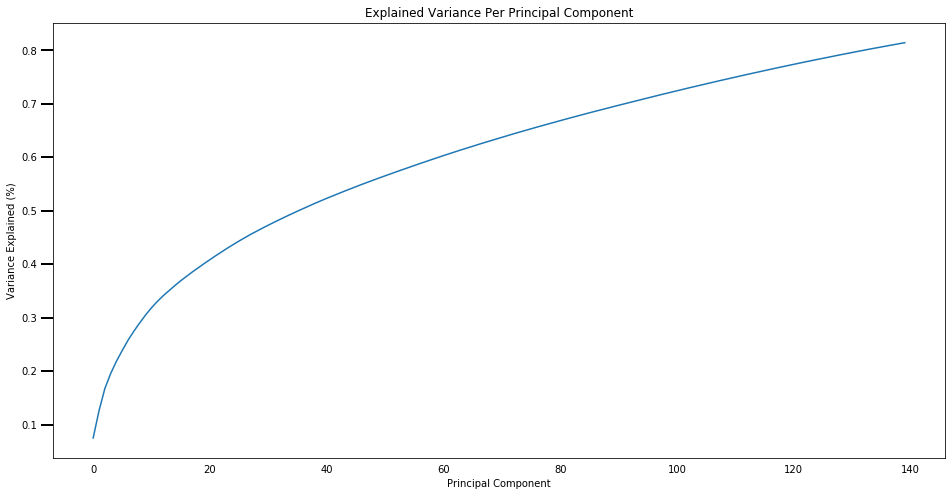

In [8]:
def scree_plot(pca):
    #Creates a scree plot associated with the principal components 

    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)

    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)

In [9]:
len(pca.components_[0])

361

# Interpretation of Principal Components

Principal components are new variables that are constructed as linear combinations of the initial variables. An important thing to realize here is that, the principal components are less interpretable and don’t have any real meaning since they are constructed as linear combinations of the initial variables.
Geometrically speaking, principal components represent the directions of the data that explain a maximal amount of variance, that is to say, the lines that capture most information of the data.
Source: https://builtin.com/data-science/step-step-explanation-principal-component-analysis

In [ ]:
def list_component(df, pca, nth_compo):
    #listing the top 10 and the bottom 10 features of a given component
    listing = pd.DataFrame({'Features':list(df.keys()),'Weights':pca.components_[nth_compo]}).sort_values('Weights', axis=0, ascending=False).values.tolist()

    return listing[:10]+['^^^HEAD','TAILvvv']+listing[-10:]

list_component(azdias_final,pca,0)

After analyzing the first component and its features from the features dataset, their description is as below:

Features on Positive Side:
PLZ8_ANTG3: number of 6-10 family houses in the PLZ8
KBA13_ANTG3: not described
KBA13_ANTG4: not described
KBA13_BAUMAX: not described
PLZ8_ANTG4: number of >10 family houses in the PLZ8
PLZ8_BAUMAX: most common building-type within the PLZ8  
CAMEO_DEUG_2015: CAMEO classification 2015 - Uppergroup 
LP_STATUS_GROB_1.0: social status rough
CAMEO_INTL_2015: not desribed
HH_EINKOMMEN_SCORE: estimated household net income

Features on Negative Side:
KBA13_GBZ : not desribed
GEMEINDETYP:not desribed
FINANZ_MINIMALIST :financial typology: low financial interest
KBA05_GBZ: number of buildings in the microcell
KBA13_AUTOQUOTE: share of cars per household within the PLZ8 
KBA05_AUTOQUOT:share of cars per household
MOBI_RASTER:not desribed
KBA13_ANTG1:not desribed
PLZ8_ANTG1: number of 1-2 family houses in the PLZ8
MOBI_REGIO: moving patterns
    

Interpreting according to description of these variables, the following is summary of conclusions:

The first principal component is strongly correlated with household net income and high number of 6-10 and  >10 family houses. 
The customers living in Baumax stlye of building are important.KBA13 is not described in the attributes file but it can be related to car ownership. 
    
Financial interest being low, higher number of 1-2 family houses and low financial interest tend to negatively affect this principal component.


In [ ]:
list_component(azdias_final,pca,1)

After analyzing the second component and its features from the features dataset, their description is as below:

Features on Positive Side:
KBA13_HERST_BMW_BENZ: share of BMW & Mercedes Benz within the PLZ8
KBA13_SEG_OBEREMITTELKLASSE : share of upper middle class cars and upper class cars (BMW5er, BMW7er etc.)
KBA13_MERCEDES: share of MERCEDES within the PLZ8
KBA13_BMW: share of BMW within the PLZ8 
KBA13_SITZE_4:number of cars with less than 5 seats in the PLZ8 
KBA13_SEG_SPORTWAGEN:share of sportscars within the PLZ8 
KBA05_HERST1 : share of top German manufacturer (Mercedes, BMW)
KBA13_KMH_211: share of cars with a greater max speed than 210 km/h within the PLZ8
KBA13_KMH_250: share of cars with max speed between 210 and 250 km/h within the PLZ8
KBA13_KW_121: share of cars with an engine power more than 120 KW - PLZ8
    
  
Features on Negative Side:
KBA13_KW_0_60:share of cars up to 60 KW engine power - PLZ8 
KBA13_HERST_FORD_OPEL : share of Ford & Opel/Vauxhall within the PLZ8
KBA13_HERST_ASIEN: share of Asian Manufacturers within the PLZ8
KBA13_HALTER_20: share of car owners below 21 within the PLZ8
KBA13_SEG_KOMPAKTKLASSE: share of lowe midclass cars (Ford Focus etc.) in the PLZ8
KBA13_KMH_180: share of cars with max speed between 110 km/h and 180km/h within the PLZ8 
KBA13_HALTER_25:share of car owners between 21 and 25 within the PLZ8 
KBA13_KMH_140_210: share of cars with max speed between 140 and 210 km/h within the PLZ8
KBA13_SEG_KLEINWAGEN: share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the PLZ8
KBA13_SITZE_5:number of cars with 5 seats in the PLZ8

Interpreting according to description of these variables, the following is summary of conclusions:    

The second principal component increases with upper class cars, share of car manufacturs, share of trailers, newbuilt cars, vans, motorcycles, all-terrain
vehicles. This component is strongly correlated to ownership of some kind of a vehicle by a customer.
This principal component decreases with household net income.
High number of 6-10 and  >10 family houses negatively impact this principal component

In [ ]:
list_component(azdias_final,pca,2)

After analyzing the third component and its features from the features dataset, their description is as below:

Features on Positive Side:
FINANZ_VORSORGER : financial typology: be prepared
CJT_TYP_5: not described        
ALTERSKATEGORIE_GROB : age classification through prename analysis
CJT_TYP_6: not described  
CJT_TYP_3: not described
KOMBIALTER: not described 
CJT_KATALOGNUTZER: not described
SEMIO_LUST : affinity indicating in what way the person is sensual minded
RETOURTYP_BK_S : return type


Features on Negative Side:
RT_KEIN_ANREIZ: not described
SEMIO_RAT : affinity indicating in what way the person is of a rational mind
SEMIO_REL : affinity indicating in what way the person is religious
SEMIO_TRADV : affinity indicating in what way the person is traditional minded
FINANZ_ANLEGER : financial typology: investor
SEMIO_PFLICHT : affinity indicating in what way the person is dutyfull traditional minded
FINANZ_UNAUFFAELLIGER : financial typology: unremarkable
FINANZ_SPARER : financial typology: money saver
CJT_TYP_2: not described
CJT_TYP_1: not described


Interpreting according to description of these variables, the following is summary of conclusions:

The third principal component is primarily affected by high end car ownership. People who own a lot of luxury cars such as BWM and Mercedes increase this component.
The cars with speed in range upto 210 and 210-250, with high engine power, less than 5 seats positively affects this component.
On the other hand, people who own budget cars, Asian manufactured cars, moderate engines, small and very small cars decrease this component. 
The car owners who are young below 21, and 21-25 indicating young owners with midsize cars are inversely related to this component.


# Clustering

K Means clustering is used on PCA transformed data.
Try to find the ideal number of clusters using the elbow method.The data is refit to final number of clusters
It is to be noted that it would take a long time to perform clustering for more number of clusters and since the dataset is huge

In [10]:
from sklearn.cluster import KMeans

In [11]:
scores = []

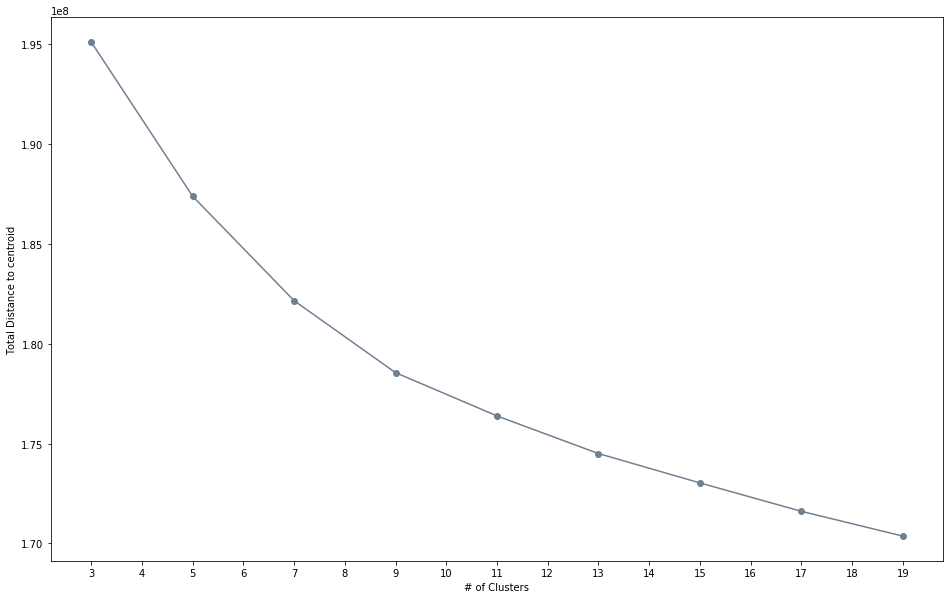

In [12]:
# Determining the number of clusters by elbow method
scores = {}
for k in range(3,20,2):
    # run k-means clustering on the data and...
    scores[k] = np.abs(KMeans(n_clusters=k, n_jobs=-1).fit(X_pca).score(X_pca))
#     1print('Calculated: ', k)

# Plot relationship plot
fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='slategray')
ax.set_xticks(np.arange(3,20), minor=False);  
ax.set_xlabel("# of Clusters")
ax.set_ylabel("Total Distance to centroid");

In [13]:
# refit the model to final clusters 
final_model = KMeans(9) # 9 is decided to be the final number of clusters
final_model.fit(X_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [14]:
# Making prediction on the principal component data
gen_preds = final_model.predict(X_pca)

In [15]:
# Apply all steps on Customer data

In [16]:
#PCA on customer data
X_pca_c = do_pca(pca, customers_final)

In [17]:
# Clustering on customer data
preds = final_model.predict(X_pca_c)

# General Data  vs Customers Data : Compare the Clusters

In [18]:
# Creating dataframes of predictions on Customer data and General Data
df_preds_cust = pd.DataFrame(preds,columns=['cust_preds'])
df_preds_gen =  pd.DataFrame(gen_preds,columns=['gen_preds'])

In [19]:
prop_cust = df_preds_cust['cust_preds'].value_counts().sort_index()/ \
                sum(df_preds_cust['cust_preds'].value_counts())
prop_gen = df_preds_gen['gen_preds'].value_counts().sort_index()/ \
                sum(df_preds_gen['gen_preds'].value_counts())

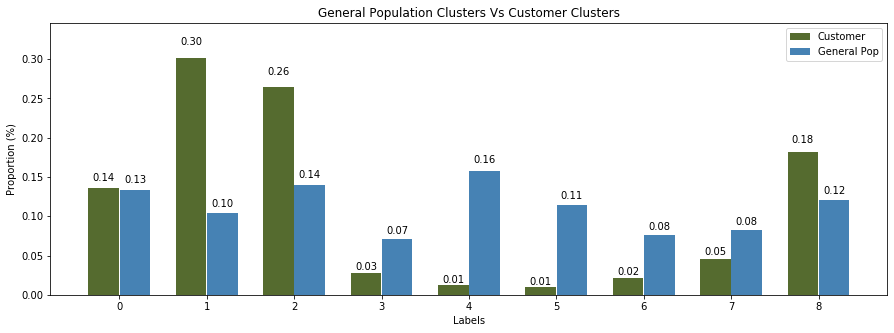

In [20]:
# Create a multiple bar chart indicating in which factors customer and general data is under or over represented
fig,ax = plt.subplots(figsize=(15,5))
width = 0.35

cust = ax.bar(prop_cust.index-.51*width, prop_cust, width, color='darkolivegreen')
gen = ax.bar(prop_gen.index+.51*width, prop_gen, width, color='steelblue')


ax.set_ylabel('Proportion (%)')
ax.set_xlabel('Labels')
ax.set_title('General Population Clusters Vs Customer Clusters')
ax.set_xticks(prop_cust.index)
ax.set_ylim(top=max(prop_cust.append(prop_gen))*1.15)
ax.legend(('Customer','General Pop'))

def label(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

label(cust)
label(gen)

In [21]:
centroid = final_model.cluster_centers_[0]
centroid_df = pd.DataFrame(centroid,columns=['pca_weights'])

# Sort the centroid in descending order
centroid_df.reindex(centroid_df.abs().sort_values('pca_weights',ascending=False).index).head()

,pca_weights
2,3.641084
0,2.311447
4,-1.518502
8,-1.022968
3,-0.899771


In [22]:
def list_recon_component(DF, model, nth_compo, pca):
    #reversing the reduction to get back to the original features
    listing = pd.DataFrame({'Features':list(DF.keys()),'Weights':pca.inverse_transform(model.cluster_centers_)[nth_compo]}).sort_values('Weights', axis=0, ascending=False).values.tolist()
    
    return listing

def plt_scaled_comparison(df_sample, kmeans, cluster):
    #plotting the clusters and their composition helper function
    X = pd.DataFrame.from_dict(dict(zip(df_sample.columns,
                                        pca.inverse_transform(kmeans.cluster_centers_[cluster]))),
                               orient='index').rename(columns={0: 'feature_values'}).sort_values('feature_values',
                                                                                                 ascending=False)
    X['feature_values_abs'] = abs(X['feature_values'])
    pd.concat((X['feature_values'][:10], X['feature_values'][-10:]), axis=0).plot(kind='barh');

In [23]:
def plt_cluster(df, model, cluster_list, title):
    #plotting the clusters and their composition
    size=len(cluster_list)
    plt.figure(figsize=(16, size*5))
    for i in range(size):
        plt.subplot(size,1,i+1)
        plt_scaled_comparison(df, model, cluster_list[i])
        plt.title(title + ' cluster ' + str(cluster_list[i]))
    plt.show()

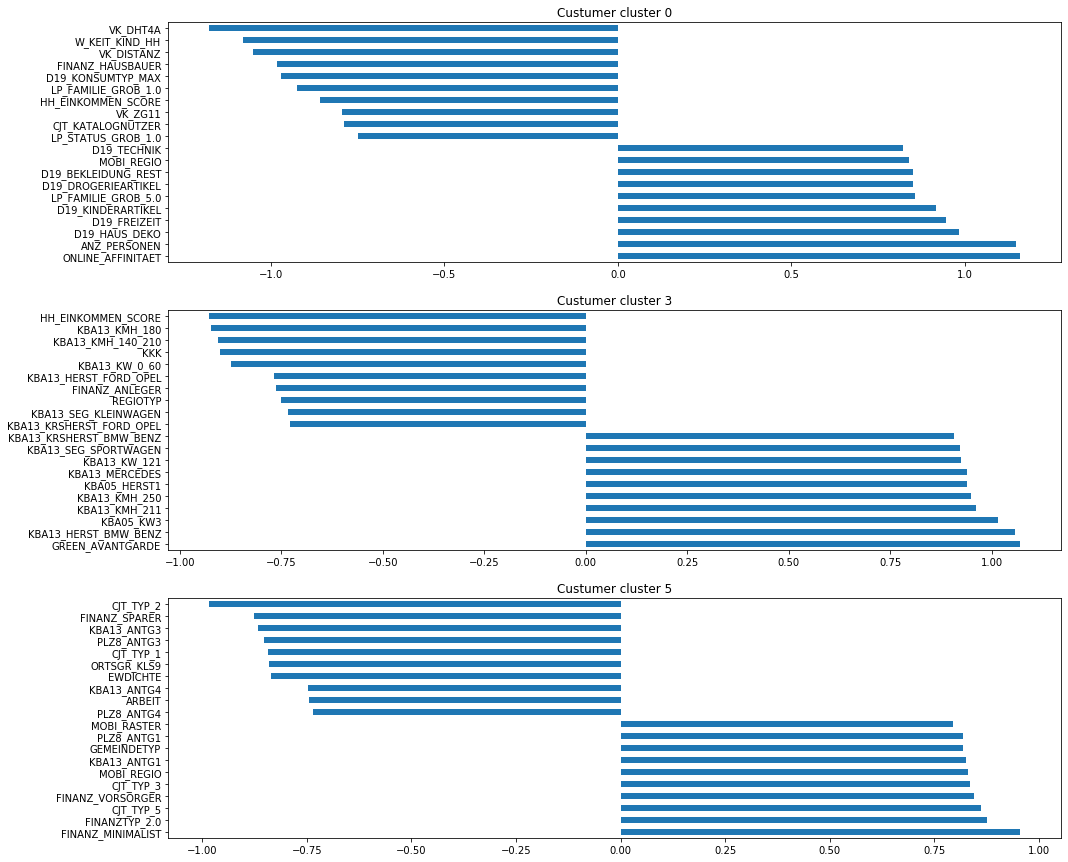

In [25]:
plt_cluster(customers_final, final_model, [0,3,5], 'Custumer')

### Each cluster describes characteristics of one type customer.

#### Cluster 0 

Many attributes of this cluster have not been described.Customers in this cluster have :   
- High affinity to online buying (0: no to 5: very high)
- More number of adults in a Family
- Single parent type family household(1- single to 11: mulitperson )
- High Mobility (1: high mobility to 6: no mobility)


This cluster is negatively impacted by customers who:
- Have likely presence of a child
- Single person type of household
- Have a financial typology where main focus is the owning a house
- Mostly inacative consumption (1: universal to 9 inactive)
- Have low household net income (1 highest income to 6 very low income)
          
           
#### Conclusion: The customers in this cluster have more affinity to online shopping, have more adults in family and have high mobility.           
     

#### Cluster 3

Attributes that positively impact this cluster is presence of customers who are:
- More green avantgarde 
- Have high share of top German manufacturers (Mercedes, BMW)
- Have high share of sportscars and high end cars like Mercedes Benz
- Their cars have powerful engines of power more than 120 KW and with max speed between 210 and 250 km/h


Customers who are negatively impacting this cluster:
- Have low household net income (1 highest income to 6 very low income)
- Low purchasing power (1 very high to 4 very low)
- They belong to 'investor' financial category
- Belong to marginalized neighbourhood (1 upper class to 7 marginalized)
- Have higher share of smaller cars and very small cars with 51 and 60 KW engine power 
- Their cars have and max speed between 140 and 210 km/h 110 km/h and 180km/h


#### Conclusion: This cluster is positively influnced by customers who have high end sports and luxury cars.

#### Cluster 5 

Customers effecting this cluster have:
- Belong to Finacial typology of low interst be prepared  
- Majorly belong to highest finanztyp criteria 'unremarkable' (1 low financial interest to 6 unremarkable)
- High Mobility (1: high mobility to 6: no mobility)
- Have mostly 1-2 family houses 
    
    
Following attributes are negatively impacting this cluster. The customers here:
- Belong to money saver financial typology
- High density of inhabitants per square kilometer (1 : less than 34 to 9 more than 999)
- Have Have 6-10 family houses or more than 10 family houses 
- High size of the community ( 1 <=2000 inhabitants to 9: >700k inhabitants)


#### Conclusion: This cluster is mostly influenced by customers living in 1-2 family house areas and have lots of disposable finacial status.


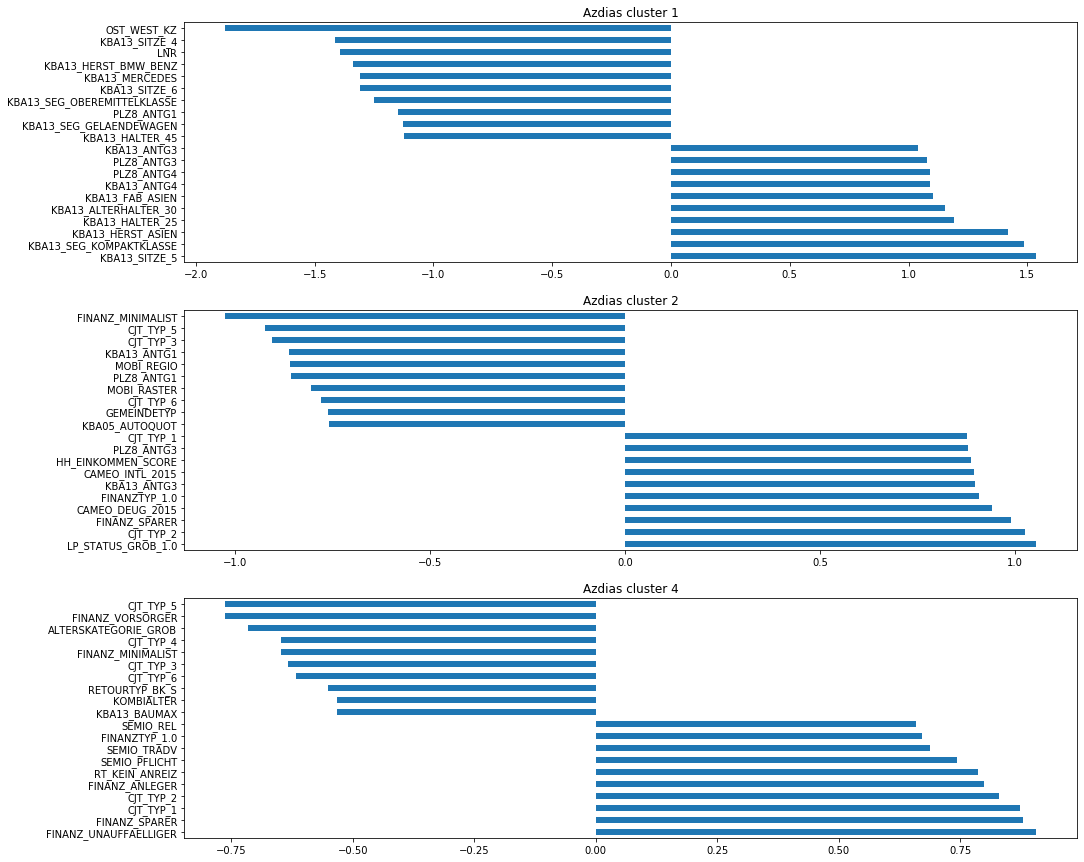

In [26]:
plt_cluster(azdias_final, final_model, [1,2,4], 'Azdias')

### Each cluster describes one type of customer.

### Cluster 1 

Positive factors that effect this cluster point to type of customers who have:
- High number of cars with 5 seats 
- High share of lowe midclass cars (Ford Focus etc.) 
- High share of Asian Manufacturers of cars
- Have Have 6-10 family houses or more than 10 family houses 
- High share of young car owners between 21 and 25 and below 30

The negatively impacting factors to this cluster include Customers who have:
    
- High number of small cars with less than 5 seats   
- Being in West Germany
- Have high share of top German manufacturers (Mercedes, BMW) and  upper class cars (BMW 7er etc.)
- Have bigger cars with more than 5 seats
- Have high share of all terrain vehicles
- High share of car owners between 31 and 45 

    
#### Conclusion: The general population has averge young aged middle class buyers with small and asian cars.



### Cluster 2 

Positive factors of this cluster has type of customers who have:
- Single parent type family household(1- single to 11: mulitperson )
- Have high financial typology of moneysaver
- Have low household net income (1 highest income to 6 very low income)
- Have high Number of 6-10 family houses 

Negatively impacting cluster are factors related to Customers who have:
- Have a financial typology of low financial interest   
- High number of 1-2 family homes
- High Mobility (1: high mobility to 6: no mobility)
- High share of cars per household( 1: very low to 5: very high)
    
    
#### Conclusion: This cluster of general population has people with rough family household type of single parent with moneysaver financial typology and have low household income


### Cluster 4

Positive factors of this cluster has type of customers who have:
- Majorly belong to highest finanztyp criteria investor, unremarkable  and money saver  
- Low affinity of customer being dutyfull traditional minded(1 highest affinity to 7 lowest affinity )    
- Low affinity of customer being traditional minded (1 highest affinity to 7 lowest affinity )
- Low affinity of customer being religious minded (1 highest affinity to 7 lowest affinity )
    

Negatively impacting cluster are factors related to Customers who have:
- Have a financial typology of being prepared and havign low financial interest    
- High age in age classification through prename analysis (1 <30 years and 4>60 years)  
- Determined minimal returner that is less susceptible to influences
    

#### Conclusion: This cluster mainly consists of general population who have more disposable money to invest and who have low affinity to being religious minded and traditional minded.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [24]:
mailout_train=pd.read_csv(r'mailout_train.csv')

C:\Users\Joykaus\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [25]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [26]:
# Imbalance of REPONSE column
vc = mailout_train['RESPONSE'].value_counts()
vc

0    42430
1      532
Name: RESPONSE, dtype: int64

In [27]:
# positive response
vc[1]/(vc[0]+vc[1])

0.012383036171500396

In [28]:
# negative response
vc[0]/(vc[0]+vc[1])

0.9876169638284996

In [29]:
# find features to drop because of many missing values
missing_per_column = mailout_train.isnull().mean()

(array([114.,   0.,   0.,   0.,   0.,  16., 229.,   2.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          3.]),
 array([0.        , 0.0293837 , 0.05876739, 0.08815109, 0.11753478,
        0.14691848, 0.17630218, 0.20568587, 0.23506957, 0.26445327,
        0.29383696, 0.32322066, 0.35260435, 0.38198805, 0.41137175,
        0.44075544, 0.47013914, 0.49952283, 0.52890653, 0.55829023,
        0.58767392, 0.61705762, 0.64644131, 0.67582501, 0.70520871,
        0.7345924 , 0.7639761 , 0.7933598 , 0.82274349, 0.85212719,
        0.88151088, 0.91089458, 0.94027828, 0.96966197, 0.99904567]),
 <a list of 34 Patch objects>)

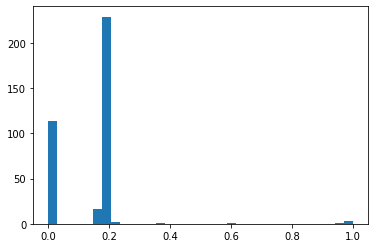

In [30]:
plt.hist(missing_per_column, bins=34)

In [42]:
start = time.time()

# clean data, no splitting of rows necessary
mailout_train = clean_data(mailout_train, notknowns)
mailout_train.shape

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Total execution time: 3.12 seconds


In [43]:
mailout_train.shape

(33266, 361)

In [44]:
mailout_train.head(10)

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0
0,1763.0,1.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,...,0,1,0,0,0,0,0,1,0,1
1,1771.0,4.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,...,0,0,1,0,0,0,1,0,1,0
2,1776.0,1.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,...,1,1,0,0,0,0,0,1,1,0
3,1460.0,1.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,...,0,1,0,0,0,1,0,0,0,1
4,1783.0,1.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,...,0,1,0,0,0,1,0,0,1,0
5,1789.0,1.0,17.0,0.0,0.0,1.0,11.0,0.0,4.0,1.0,...,0,1,0,0,0,0,0,1,1,0
6,1795.0,1.0,2.0,0.0,0.0,1.0,1.0,0.0,3.0,6.0,...,1,1,0,0,1,0,0,0,0,1
7,1493.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,7.0,...,0,1,0,0,1,0,0,0,1,0
11,2512.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,7.0,...,0,1,0,0,0,0,1,0,1,0
12,2513.0,1.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,6.0,...,0,0,0,1,0,1,0,0,1,0


In [45]:
# extract RESPONSE column
response = mailout_train['RESPONSE']

In [46]:
# drop RESPONSE column
mailout_train.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [48]:
# impute median and scale azdias
imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

In [49]:
mailout_train_imputed = pd.DataFrame(imputer.fit_transform(mailout_train))
mailout_train_scaled = scaler.fit_transform(mailout_train_imputed)

In [50]:
mailout_train_scaled.shape

(33266, 360)

In [51]:
response.shape

(33266,)

In [52]:
import warnings; warnings.simplefilter('ignore')

In [53]:
def classify(clf, param_grid, X_train=mailout_train_scaled, y_train=response):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X_train (DataFrame): training input
    - y_train (DataFrame): training output
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X_train, y_train)
    print(grid.best_score_)
    
    return grid.best_estimator_


In [54]:
# Using Logistic Regression
start = time.time()

# LogisticRegression
logreg = LogisticRegression(random_state=12)
classify(logreg, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.6527923552689312
Total execution time: 7.57 seconds


In [55]:
# Applying Bagging Classifier
start = time.time()

# BaggingClassifier
bac = BaggingClassifier(random_state=12)
classify(bac, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.54322308855272
Total execution time: 90.09 seconds


In [56]:
# Applying AdaBoostClassifier
start = time.time()

# AdaBoostClassifier
abc = AdaBoostClassifier(random_state=12)
abc_best_est = classify(abc, {})


end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.6832676898163734
Total execution time: 145.15 seconds


In [57]:
# Applying GradientBoostingClassifier
start = time.time()

# GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=12)
classify(gbc, {})

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

0.7024148976583418
Total execution time: 791.07 seconds


In [1]:
# Tuning Gradient boost classifier 
gbc = GradientBoostingClassifier(random_state=12)
param_grid = {'loss': ['deviance', 'exponential'],
              'max_depth': [2, 3],
              'n_estimators':[80],
              'random_state': [12]
             }

start = time.time()

gbc_tuned = classify(gbc, param_grid)
gbc_tuned

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

In [60]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

# Initialize 5 stratified folds
skf = StratifiedKFold(n_splits=5, random_state=12)
skf.get_n_splits(mailout_train, response)
print(skf)

StratifiedKFold(n_splits=5, random_state=12, shuffle=False)


In [61]:
# creating Pipeline 
def create_pipeline(clf):
    
    # Create machine learning pipeline
    pipeline = Pipeline([
        ('imp', imputer),
        ('scale', scaler),
        ('clf', clf)
    ])
    
    return pipeline


In [62]:

def cross_validate(clf):

    pipeline = create_pipeline(clf)
    scores = []
    i = 0

    # Perform 5-fold validation
    for train_index, test_index in skf.split(mailout_train, response):
        i+=1
        print('Fold {}'.format(i))
        
        # Split the data into training and test sets
        X_train, X_test = mailout_train.iloc[train_index], mailout_train.iloc[test_index]
        y_train, y_test = response.iloc[train_index], response.iloc[test_index]

        # Train using the pipeline
        pipeline.fit(X_train, y_train)

        #Predict on the test data
        y_pred = pipeline.predict(X_test)

        score = roc_auc_score(y_test, y_pred)
        scores.append(score)
        print("Score: {}".format(score))
        
    return scores

In [63]:
from sklearn.metrics import roc_auc_score

start = time.time()

tuned_scores = cross_validate(gbc)

end = time.time()
elapsed = end - start
print("Total execution time: {:.2f} seconds".format(elapsed))

Fold 1
Score: 0.49946735656673263
Fold 2
Score: 0.49946735656673263
Fold 3
Score: 0.4997717242428854
Fold 4
Score: 0.4995434484857708
Fold 5
Score: 0.49992389649923896
Total execution time: 215.46 seconds


In [64]:
#pip install xgboost

In [65]:
y = response
X = mailout_train_scaled

In [66]:
from sklearn.model_selection import train_test_split 
seed = 83
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=0.2)

In [67]:
# Applying XGBoost Classifier
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1.0, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=50, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.6, verbose=1)

In [68]:
clf.fit(X_train, y_train, eval_metric='auc', verbose=True, 
        eval_set=[(X_test, y_test)], early_stopping_rounds=50)

[0]	validation_0-auc:0.50000
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.65236
[2]	validation_0-auc:0.65236
[3]	validation_0-auc:0.65236
[4]	validation_0-auc:0.70890
[5]	validation_0-auc:0.70890
[6]	validation_0-auc:0.69386
[7]	validation_0-auc:0.68937
[8]	validation_0-auc:0.69943
[9]	validation_0-auc:0.69943
[10]	validation_0-auc:0.70905
[11]	validation_0-auc:0.70605
[12]	validation_0-auc:0.70407
[13]	validation_0-auc:0.69931
[14]	validation_0-auc:0.71799
[15]	validation_0-auc:0.71555
[16]	validation_0-auc:0.71846
[17]	validation_0-auc:0.71567
[18]	validation_0-auc:0.72017
[19]	validation_0-auc:0.71945
[20]	validation_0-auc:0.72140
[21]	validation_0-auc:0.72408
[22]	validation_0-auc:0.72865
[23]	validation_0-auc:0.72564
[24]	validation_0-auc:0.73142
[25]	validation_0-auc:0.74040
[26]	validation_0-auc:0.73858
[27]	validation_0-auc:0.73707
[28]	validation_0-auc:0.73368
[29]	validation_0-auc:0.73553
[30]	validation_0-auc:0.73540
[31]	validation_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=50, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=1, nthread=1, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
              subsample=0.6, tree_method=None, validate_parameters=False,
              verbose=1, ...)

In [71]:
y_test_pred = clf.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_test_pred)

0.7403977791299057

Hence we select XGBClassifier as it gives the highest roc_auc_score out of all the classifiers.

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [73]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [74]:
mailout_test= pd.read_csv(r'mailout_test.csv')

In [75]:
mailout_test.head(10)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4
5,1782,2,1.0,7.0,NaN,NaN,NaN,NaN,7.0,66.0,...,4.0,9.0,10.0,7.0,6.0,9.0,3.0,6,1,4
6,1485,2,1.0,10.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,1.0,2.0,1.0,6.0,9.0,3.0,3,2,4
7,1519,-1,1.0,20.0,NaN,NaN,NaN,NaN,15.0,1.0,...,2.0,4.0,5.0,4.0,2.0,9.0,3.0,4,2,3
8,1835,1,1.0,19.0,NaN,NaN,NaN,NaN,13.0,2.0,...,1.0,1.0,1.0,1.0,4.0,9.0,7.0,1,2,3
9,1522,1,1.0,0.0,NaN,NaN,NaN,NaN,9.0,1.0,...,2.0,5.0,8.0,9.0,3.0,4.0,2.0,4,1,3


In [76]:
# Here only columns are dropped as we need to predict on all the rows 
def clean_data_final(x, notknowns):
    """
   
    INPUT: 
        azdias: Population/Customer demographics DataFrame
        feat_info: feat info DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
   
    # Convert missing values to Nans
    for col in x.columns:
        if x[col].dtype == np.int64:
            x[col] = x[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in notknowns['attribute']:
        if row in x.columns:
            na_map = notknowns.loc[notknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = x.loc[:, row].isin(na_map)
            x.loc[na_idx, row] = np.NaN
        else:
            continue

   # remove selected columns, ...
    # These columns had more than 20% data missing values in the azdias dataframe
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    x.drop(cols_to_drop, axis=1, inplace = True)
    
        
    # select, re-encode, and engineer column values
    x['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(x[col], prefix = col)
        x = pd.concat([x, dummy], axis = 1)
        
    x.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE','EINGEFUEGT_AM']
    
    x.drop(cols_to_drop, axis=1, inplace = True)
    
    
    # replacing values for CAMEO_INTL_2015
    x['CAMEO_INTL_2015'] = x['CAMEO_INTL_2015'].replace('XX',-1)
    
    # replacing values for CAMEO_DEUG_2015
    x['CAMEO_DEUG_2015'] = x['CAMEO_DEUG_2015'].replace('X',-1)
    
    
    # Return the cleaned dataframe.
    return x

In [77]:

# clean data
mailout_test = clean_data_final(mailout_test, notknowns)
mailout_test.shape

(42833, 360)

In [78]:
lnr = mailout_test.LNR

In [79]:
# impute median and scale azdias 
mailout_test_imputed = pd.DataFrame(imputer.transform(mailout_test))
mailout_test_scaled = scaler.transform(mailout_test_imputed)

In [80]:
mailout_test_scaled.shape


(42833, 360)

In [81]:
# use the trained model from Part 2 to predict the probabilties of the testing data 
response_test = clf.predict_proba(mailout_test_scaled)
response_test

array([[0.9490619 , 0.0509381 ],
       [0.9487106 , 0.05128939],
       [0.959174  , 0.04082602],
       ...,
       [0.94635874, 0.05364127],
       [0.95848763, 0.04151239],
       [0.94842637, 0.05157364]], dtype=float32)

In [82]:
response_test.shape

(42833, 2)

In [83]:
#submission = pd.DataFrame(index=mailout_test['LNR'].astype('int32'), data=response_test[:,0])
submission=pd.DataFrame({'LNR':lnr.astype(np.int32), 'RESPONSE':response_test[:, 1]})

In [84]:
submission.head()

,LNR,RESPONSE
0,1754,0.050938
1,1770,0.051289
2,1465,0.040826
3,1470,0.039993
4,1478,0.044462


In [85]:
submission.to_csv('submission1.csv', index=False)

Kaggle Score:0.69

## Conclusion and future recommendations
- This project provided a hands on opportunity to experience real world data science problem. It may have great practical implications in other projects we do.
- The unsupervised machine learning through dimensionality reduction techniques was quite a learning experience.
- xgboost classifier was selected because that model provided the highest score..
- Many categorical variables with more than 10 levels was dropped.The lack of description for many variables made their PCA analysis tough.
- There is further room for improvement in roc scores by tuning the classification model parameters.